Imports for topic modelling

In [75]:
import os
import pandas as pd
import numpy as np
from pathlib import Path
from wordcloud import WordCloud
from nltk.stem.snowball import SnowballStemmer
import nltk
from nltk.corpus import stopwords
#nltk.download('stopwords') # only download once
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import LatentDirichletAllocation as LDA
import time
warnings.simplefilter("ignore", DeprecationWarning)
import spacy
import de_core_news_lg
nlp = de_core_news_lg.load(disable=['parser'])
import datetime
from gensim import corpora,models
import pyLDAvis.gensim
from gensim.utils import simple_preprocess
from gensim.test.utils import common_corpus
from gensim.models import LdaSeqModel
from gensim.test.utils import datapath
from importlib import reload
import logging
import re
logging.basicConfig(filename='gensim5.log',filemode='w',
                    format="%(asctime)s:%(levelname)s:%(message)s",
                    level=logging.INFO)
reload(logging)
from gensim.models import CoherenceModel
warnings.filterwarnings("ignore",category=DeprecationWarning)
import tqdm
import gensim
# Enable in-notebook visualizations
%matplotlib inline
pyLDAvis.enable_notebook()
pd.options.display.max_rows = 50
pd.options.display.min_rows = 15

my_path = "/home/sim/all/Master/Forschungspraktikum/Tagesschau/"
print('done')

done


Build dataframes from text data, 
each text-file contains one tagesschau transcription.

In [76]:
# load the s2t transcriptions
def load_transcriptions(path):
    os.chdir(path)
    transcriptions = os.listdir()#[:30]
    return transcriptions

# Preprocessing for topic modelling, in this case LDA
# use SpaCy Pipe for faster lemmatizing
def preprocess_pipe(texts):
    preproc_pipe = []
    for doc in nlp.pipe(texts, batch_size=int(len(texts)/n_cpu_cores),n_process=int(n_cpu_cores)):
        preproc_pipe.append([str(word.lemma_).lower() for word in doc if not word.is_stop and word.is_alpha])
    return preproc_pipe


# preprocess transcriptions: remove: "newline", punctuations, stopwords (automatically and manually chosen ones
# create bi-/tri-grams and add meta-data date.
def preprocess_transcriptions(transcripts_df,number_cpu_cores=os.cpu_count()-1):
    

    # save transcriptions of tagesschau in DataFrame
    df = pd.DataFrame(index=[i for i in range(len(transcriptions)) if "tagesschau" in transcriptions[i]], columns=['transcriptionName','content','preprocessed','year','month','day'])
    for transcription in range(len(transcriptions)):
        if "tagesschau" in str(transcriptions[transcription]) and 'vor' not in str(transcriptions[transcription]):
            with open(transcriptions[transcription], "r") as f:
                df.at[transcription,'transcriptionName'] = str(transcriptions[transcription])
                df.at[transcription,'content'] = f.read()
    df = df.reset_index()
    
    # remove "newline" and punctuation
    for transcript in range(len(df)):
        df.at[transcript,'preprocessed'] = df.loc[transcript,'content'].replace("\n","").replace(".","")
    start_timer_preprocess = datetime.datetime.now()
    df['preprocessed'] = preprocess_pipe(df['preprocessed'])
    
    print("lemmatizing needs:",round((datetime.datetime.now()-start_timer_preprocess).total_seconds(),2),"seconds")

    # Create substitutions for a better overview and easier usage/changing of manual stopwords.
    # Furthermore, useable for correcting of text2speech (korona->corona)
    manual = [[['wetter'],['sonne','regen','wind','schnee','schauer','luft','wolken','gewitter','gewittern']],
              [['himmelsrichtung'],['norden','sueden','osten','westen']],
              [['wochentag'],['montag','dienstag','mittwoch','donnerstag','freitag','samstag','sonntag']],
              [['monat'],['januar','februar','maerz','april','mai','juni','juli','august','september','oktober','november','dezember']],
              [['corona'],['korona']]]
    
    start_manual = datetime.datetime.now()
    
    # Apply above manual substitutions
    for i in range(len(df)):
        for k in manual:
                for l in range(len(k[1])):
                    df.at[i,'preprocessed'] = [k[0][0] if k[1][l]==x else x for x in df.loc[i,'preprocessed']]
    
    print("replacing e.g. 'sonne','regen'... by 'wetter' needs:",
          round((datetime.datetime.now()-start_manual).total_seconds(),2),"seconds")    
    
    # As we use automatic stopword removal (+ filter_extreme method later), we only remove weather, cardinal direction, 
    # weekday and month
    manual_stopwords = ['wetter','wochentag','monat','himmelsrichtung']
    
    # Remove manual chosen stopwords.
    for i in range(len(df)):
        df.at[i,'preprocessed'] = [word for word in df.loc[i,'preprocessed'] if word not in manual_stopwords]
        
    # Create bi-/tri-grams for words which occur together multiple times.
    start_bi_trigram = datetime.datetime.now()
    list_of_all_for_bigram = []
    for i in range(len(df)):
        list_of_all_for_bigram.append(df.loc[i,'preprocessed'])
    bigram = models.Phrases(list_of_all_for_bigram, min_count=20, threshold=50)
    trigram = models.Phrases(bigram[list_of_all_for_bigram], threshold=50)
    bigram_mod = models.phrases.Phraser(bigram)
    trigram_mod = models.phrases.Phraser(trigram)
    for i in range(len(df)):
        df.at[i,'preprocessed'] = bigram_mod[df.loc[i,'preprocessed']]
        df.at[i,'preprocessed'] = trigram_mod[bigram_mod[df.loc[i,'preprocessed']]]
    for i in range(len(df)):
        df.at[i,'preprocessed'] = (','.join(df.loc[i,'preprocessed'])).replace(','," ")
    
    print("Bi-/Tri-Grams needs:",round((datetime.datetime.now()-start_bi_trigram).total_seconds(),2),"seconds")
    
    
    # save metadata of transcriptions in DataFrame
    for i in range(len(df)):
        if 'tagesschau' in df.loc[i,'transcriptionName'] and 'vor' not in df.loc[i,'transcriptionName']:
            df.at[i,'year'] = int((df.loc[i,'transcriptionName'].split('_')[1][4:8]))
            df.at[i,'month'] = int((df.loc[i,'transcriptionName'].split('_')[1][2:4]))
            df.at[i,'day'] = int((df.loc[i,'transcriptionName'].split('_')[1][0:2]))
    
    return df

Preprocess data for given daterange in yearly portions for feasibility in terms of RAM usage.

In [79]:
%%time
# set Path
my_path = "/home/sim/all/Master/Forschungspraktikum/Tagesschau/"
n_cpu_cores = int(os.cpu_count()/2-1)
print("number cpu_cores to use:",n_cpu_cores)
df_all_processed = pd.DataFrame(index=[], columns=['preprocessed'])


#load speech2text transcriptions
path = my_path+"transcripts/"
transcriptions = load_transcriptions(path)
keys = ['2007','2008','2009','2010','2011','2012','2013','2014','2015','2016','2017','2018','2019','2020']
years_dict = {}
for year in keys: 
    years_dict[year] = []

# prepare daterange of interest for lda
daterange = pd.date_range(datetime.datetime(2006, 12, 19), datetime.datetime(2021, 11, 11))
dates_of_interest = []
for date in daterange:
    for i in transcriptions:
        if 'tagesschau' in i and 'vor' not in i:
            year = int((i.split('_')[1][4:8]))
            if year==date.year:
                month = int((i.split('_')[1][2:4]))
                if month == date.month:
                    day = int((i.split('_')[1][0:2]))
                    if day == date.day:
                        years_dict[str(year)].append(i)
                        dates_of_interest.append(i)
print("There are ",len(dates_of_interest),"transcriptions in given daterange")

yearsLen = []
# preprocess every year
for year in years_dict.keys():
    print("\npreprocess transcriptions of year:",year,", quantity:",len(years_dict[str(year)]))
    if len(years_dict[str(year)]) > 0:
        yearsLen.append(len(years_dict[str(year)]))
    if len(years_dict[str(year)]) == 0:
        print("no transcription for year:",year)
        continue
    start = datetime.datetime.now()
    transcriptions = years_dict[str(year)]
    df_processed = preprocess_transcriptions(transcriptions,number_cpu_cores=n_cpu_cores)
    df_all_processed = pd.concat([df_all_processed,df_processed],ignore_index=True)
    

display(df_all_processed)
          
print("length of DataFrame:",len(df_all_processed))

print("number of transcriptions of each year in chosen daterange:",yearsLen)

# save lda
df_all_processed.to_csv(my_path+"ldas/df.csv",sep=',',index=False)

print("\ndone")

number cpu_cores to use: 7
There are  4926 transcriptions in given daterange

preprocess transcriptions of year: 2007 , quantity: 263
lemmatizing needs: 22.35 seconds
replacing e.g. 'sonne','regen'... by 'wetter' needs: 0.49 seconds
Bi-/Tri-Grams needs: 5.03 seconds

preprocess transcriptions of year: 2008 , quantity: 357
lemmatizing needs: 31.41 seconds
replacing e.g. 'sonne','regen'... by 'wetter' needs: 0.67 seconds
Bi-/Tri-Grams needs: 6.06 seconds

preprocess transcriptions of year: 2009 , quantity: 357
lemmatizing needs: 31.01 seconds
replacing e.g. 'sonne','regen'... by 'wetter' needs: 0.67 seconds
Bi-/Tri-Grams needs: 6.06 seconds

preprocess transcriptions of year: 2010 , quantity: 357
lemmatizing needs: 29.75 seconds
replacing e.g. 'sonne','regen'... by 'wetter' needs: 0.65 seconds
Bi-/Tri-Grams needs: 5.88 seconds

preprocess transcriptions of year: 2011 , quantity: 353
lemmatizing needs: 29.95 seconds
replacing e.g. 'sonne','regen'... by 'wetter' needs: 0.67 seconds
Bi-/Tri

,preprocessed,index,transcriptionName,content,year,month,day
0,deutsch_fernsehen_tagesschau_gut abend_dame_he...,0.0,tagesschau_01042007_2000_.txt,hier ist das erste deutsche Fernsehen mit der ...,2007,4,1
1,deutsch_fernsehen_tagesschau abend_dame_herr j...,1.0,tagesschau_02042007_2000_.txt,hier ist das erste deutsche Fernsehen mit der ...,2007,4,2
2,deutsch_fernsehen_tagesschau_gut abend_dame_he...,2.0,tagesschau_03042007_2000_.txt,hier ist das erste deutsche Fernsehen mit der ...,2007,4,3
3,deutsch_fernsehen_tagesschau_gut abend_dame_he...,3.0,tagesschau_04042007_2000_.txt,hier ist das erste deutsche Fernsehen mit der ...,2007,4,4
4,deutsch_fernsehen_tagesschau dame_herr iran fe...,4.0,tagesschau_05042007_2000_.txt,hier ist das erste deutsche Fernsehen mit der ...,2007,4,5
5,deutsch_fernsehen_tagesschau_gut abend_dame_he...,5.0,tagesschau_06042007_2000_.txt,hier ist das erste deutsche Fernsehen mit der ...,2007,4,6
6,deutsch_fernsehen_tagesschau_gut abend_dame_he...,6.0,tagesschau_07042007_2000_.txt,hier ist das erste deutsche Fernsehen mit der ...,2007,4,7
...,...,...,...,...,...,...,...
4919,deutsch_fernsehen_tagesschau_studio jens_riewa...,325.0,tagesschau_23112020_2000_.txt,hier ist das erste deutsche Fernsehen mit der ...,2020,11,23
4920,deutsch_fernsehen_tagesschau_studio thorsten_s...,326.0,tagesschau_24112020_2000_.txt,hier ist das erste deutsche Fernsehen mit der ...,2020,11,24


len of df: 4926
number of transcriptions of each year in chosen daterange: [263, 357, 357, 357, 353, 357, 362, 365, 365, 367, 365, 364, 362, 332]

done
CPU times: user 3min 56s, sys: 20.5 s, total: 4min 17s
Wall time: 9min 1s


Initialize array and dictionary to save all computed models while searching for best number of topics.

In [80]:
lda_models = []
model_coherences = {'Topics': [], 'Coherence': [], 'no_below': [], 'no_above': []}

Function to train lda and compute its coherence score

In [95]:
def train_lda_compute_coherence(corpus, texts, dictionary, n_topics, workers, no_below=20, no_above=0.5):
    global lda_models
    passes = 500
    iterations = 500
    # train LDA
    # workers: recommended is using number of pyhsical CPU cores - 1
    # for us, less cores worked better
    # minimum_probability=0 for proper usage in topic modeling over time, as you keep all probabilities.
    # chunksize with best performance when using #transcripts/workers (chunksize=transcripts, if there is enough RAM)
    # at least 500 passes and iterations to have high probability of convergence, as we have less data (~5000 transcriptions)
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=n_topics,
                                           random_state=10,
                                           chunksize=int(len(df['preprocessed'])/workers),
                                           passes=passes, 
                                           iterations=iterations,
                                           per_word_topics=True,
                                           eval_every=50, # useable for logging 
                                           workers=workers,
                                           minimum_probability=0)
                                           #callbacks=[coherence_logger]) # not supported for multicore-method
    
    
    Path(my_path+"lda/lda_"+str(n_topics)+"topics_"+str(passes)+"passes_"+str(iterations)+"iter"+str(no_below)+"no_below"+str(no_above)+"no_above").mkdir(parents=True, exist_ok=True)
    lda_model.save(my_path+"lda/lda_"+str(n_topics)+"topics_"+str(passes)+"passes_"+str(iterations)+"iter"+str(no_below)+"no_below"+str(no_above)+"no_above"+"/lda")
    coherence_model_lda = CoherenceModel(model=lda_model, texts=df['preprocessed'], dictionary=id2word, coherence='c_v')
    #lda_models.append([n_topics,lda_model,coherence_model_lda])
    return coherence_model_lda.get_coherence()

Train LDAs and obtain their coherence value with different number of topics.

In [83]:
%%time
# set Path
my_path = "/home/sim/all/Master/Forschungspraktikum/Tagesschau/"
# load transcriptions and prepare them for LDA
df_all_processed = pd.read_csv(my_path+'ldas/df1.csv', sep=',')
df_all_processed.fillna('', inplace=True)
df = df_all_processed.copy()
print("number of transcriptions:",len(df))
for i in range(len(df['preprocessed'])):
        df.at[i,'preprocessed'] = df.loc[i,'preprocessed'].split(" ")

# train for different topics and different filtering of dictionary

no_below = 20
no_above = 0.5

id2word = corpora.Dictionary(df['preprocessed'])
print("number words in dictionary before filtering:",len(id2word))
# filter dictionary for high and low frequency words
id2word.filter_extremes(no_below = 20, no_above=0.5)
print("number words in dictionary after filtering:",len(id2word))
corpus = [id2word.doc2bow(doc) for doc in df['preprocessed']]

# set topic range
min_topics = 50
max_topics = 60
step_size = 10
topics_range = range(min_topics, max_topics, step_size)


n_iterations = (len(topics_range))
print("number of iterations:", n_iterations)

# init tqdm bar for better looking logging
pbar = tqdm.tqdm(total=n_iterations)

# compute coherences for topic numbers in given range
for n_topics in topics_range:
    print(str(no_below)+"no_below"+str(no_above)+"no_above"+"\nn_topics:",n_topics)

    # get the coherence score for the given parameters
    cs = train_lda_compute_coherence(corpus=corpus,texts=df['preprocessed'], dictionary=id2word, 
                                  n_topics=n_topics, workers=2, no_below=no_below, no_above=no_above)
    print("coherence score is:",cs)
    # Save coherence-values
    model_coherences['Topics'].append(n_topics)
    model_coherences['Coherence'].append(cs)
    model_coherences['no_below'].append(no_below)
    model_coherences['no_above'].append(no_above)
    pbar.update(1)
pbar.close()
df_model_coherences = pd.DataFrame(model_coherences)
df_model_coherences.to_csv(my_path+'ldas/df_model_coherence', index=False)
print("done")


number of transcriptions: 4925
number words in dictionary before filtering: 158756
number words in dictionary after filtering: 17526



  0%|          | 0/1 [00:00<?, ?it/s]

number of iterations: 1
20no_below0.5no_above
n_topics: 50



100%|██████████| 1/1 [00:22<00:00, 22.27s/it]

coherence score is: 0.2280066563739936
done
CPU times: user 17.1 s, sys: 7.62 s, total: 24.7 s
Wall time: 29.8 s


For topic modeling over time, recreate dictionary and corpus from preprocessed data for given model.

In [84]:
df_all_processed = pd.read_csv(my_path+'ldas/df1.csv', sep=',')
df_all_processed.fillna('', inplace=True)
df = df_all_processed.copy()
print("number of transcriptions:",len(df))
for i in range(len(df['preprocessed'])):
        df.at[i,'preprocessed'] = df.loc[i,'preprocessed'].split(" ")
id2word = corpora.Dictionary(df['preprocessed'])
print("number words in dictionary before filtering:",len(id2word))
id2word.filter_extremes(no_below = 20, no_above=0.5)
print("number words in dictionary after filtering:",len(id2word))
corpus = [id2word.doc2bow(doc) for doc in df['preprocessed']]

number of transcriptions: 4925
number words in dictionary before filtering: 158756
number words in dictionary after filtering: 17526


Load a lda model and show its topics and coherence_value.

In [85]:
lda_model = gensim.models.LdaModel.load(my_path+"lda/lda_40topics_500passes_500iter20no_below0.5no_above/lda")
coherence_model_lda = CoherenceModel(model=lda_model, texts=df['preprocessed'], dictionary=id2word, coherence='c_v')
print(coherence_model_lda.get_coherence())

print(lda_model)
print("\n------------------------------------------------\n")
for idx,topic in lda_model.print_topics(-1):
        probs = ((topic.replace('"','').replace(" ","").split('+')))
        for prob in range(len(probs)):
            probs[prob] = (probs[prob].split("*"))
        probs_formatted = [str(x[1])+'('+str(x[0])+')' for x in probs]
        print('Topic: {} \nWords: {}'.format(idx+1,probs_formatted))

0.5400028288366052
LdaModel(num_terms=17526, num_topics=40, decay=0.5, chunksize=2462)

------------------------------------------------

Topic: 1 
Words: ['film(0.082)', 'jury(0.025)', 'preis(0.024)', 'auszeichnen(0.020)', 'schauspielerin(0.014)', 'festival(0.013)', 'venedig(0.013)', 'goldene(0.012)', 'preisträger(0.012)', 'golden(0.011)']
Topic: 2 
Words: ['trump(0.016)', 'china(0.015)', 'welt(0.006)', 'peking(0.005)', 'gipfel(0.005)', 'merkel(0.005)', 'präsident_trump(0.004)', 'washington(0.004)', 'protest(0.004)', 'donald_trump(0.003)']
Topic: 3 
Words: ['libyen(0.025)', 'gaddafi(0.017)', 'japan(0.015)', 'reaktor(0.013)', 'fukushima(0.013)', 'aufständische(0.012)', 'tripolis(0.011)', 'nato(0.009)', 'kraftwerk(0.009)', 'atomausstieg(0.008)']
Topic: 4 
Words: ['ägypten(0.021)', 'kairo(0.010)', 'nsa(0.009)', 'geheimdienst(0.009)', 'ägyptisch(0.008)', 'datum(0.008)', 'tunesien(0.007)', 'bnd(0.007)', 'mubarak(0.006)', 'opposition(0.005)']
Topic: 5 
Words: ['afghanistan(0.032)', 'soldat(

Show intertopic distances to get an overview of topic distribution.

In [93]:
display(pyLDAvis.gensim.prepare(lda_model, corpus, id2word))

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
36     0.026927 -0.068024       1        1  17.041941
26     0.054059 -0.071027       2        1  10.415625
39     0.042932 -0.004017       3        1   9.822531
22     0.065781 -0.099583       4        1   7.065586
31     0.055382 -0.061791       5        1   6.221673
27     0.087451  0.149505       6        1   5.002676
1      0.078579 -0.000593       7        1   3.414114
28     0.079927  0.095327       8        1   3.118426
34     0.092616  0.081039       9        1   2.974434
24     0.032066  0.042601      10        1   2.661899
20     0.049676 -0.182577      11        1   2.622046
14     0.022877  0.092574      12        1   2.535912
30     0.075937  0.128554      13        1   2.479139
25     0.076230 -0.120606      14        1   2.335658
7      0.093909 -0.056093      15        1   2.164578
4      0.061183  0.154349      16        1   2.116652
12     0.074077 -0.100638      17        1   2.007685
35     0.068112  0.118707      18        1   1.582633
6      0.061038 -0.118611      19        1   1.450920
5      0.035336  0.012810      20        1   1.325266
3      0.054165  0.095292      21        1   1.259177
37     0.059680 -0.071474      22        1   1.142715
17     0.044636  0.008577      23        1   1.102581
13     0.024386  0.026232      24        1   1.094255
38     0.010250  0.004747      25        1   1.079717
11    -0.010179 -0.052211      26        1   0.986623
10     0.004810 -0.162723      27        1   0.864325
18    -0.006776 -0.018963      28        1   0.769038
19    -0.032542  0.108960      29        1   0.695097
2     -0.038324  0.229312      30        1   0.689221
23    -0.087586 -0.054355      31        1   0.307955
33    -0.088990 -0.030512      32        1   0.306580
16    -0.032860  0.062003      33        1   0.289930
0     -0.065958 -0.018012      34        1   0.243663
32    -0.051905 -0.089824      35        1   0.230065
8     -0.062031 -0.019165      36        1   0.206411
9     -0.048859 -0.033609      37        1   0.183922
29    -0.334409  0.046343      38        1   0.133180
15    -0.296578 -0.015576      39        1   0.036897
21    -0.275027 -0.006947      40        1   0.019251, topic_info=                     Term         Freq        Total Category  logprob  loglift
3902           flüchtling  4813.000000  4813.000000  Default  30.0000  30.0000
1140             russland  4935.000000  4935.000000  Default  29.0000  29.0000
772                   spd  6427.000000  6427.000000  Default  28.0000  28.0000
179                israel  2757.000000  2757.000000  Default  27.0000  27.0000
12841                 afd  1618.000000  1618.000000  Default  26.0000  26.0000
1806              polizei  5200.000000  5200.000000  Default  25.0000  25.0000
309                soldat  3875.000000  3875.000000  Default  24.0000  24.0000
...                   ...          ...          ...      ...      ...      ...
8020              emotion     0.723421   108.998062  Topic40  -6.7335   3.5403
3409   katholische_kirche     0.937747   184.649307  Topic40  -6.4740   3.2726
9907         pakistanisch     0.694961   159.304077  Topic40  -6.7736   3.1207
5983           vorpommern     0.660499   154.793655  Topic40  -6.8245   3.0985
3316                wagen     1.505424   445.010498  Topic40  -6.0007   2.8664
5600        islamistische     0.939458   315.616760  Topic40  -6.4722   2.7384
1797             pakistan     0.897140   795.008118  Topic40  -6.5183   1.7685

[2511 rows x 6 columns], token_table=       Topic      Freq            Term
term                                  
7048      18  0.990671           abbas
3128       1  0.296265     abgeordnete
3128       2  0.276855     abgeordnete
3128       3  0.100628     abgeordnete
3128       4  0.009194     abgeordnete
3128       5  0.135363     abgeordnete
3128       7  0.006640     abgeordnete
...      ...       ...             .

For modelling the topics over time, we followed and modified instructions by
https://medium.com/the-die-is-forecast/topic-modeling-as-osint-exploring-russian-presidential-speech-topics-over-time-ad6018286d37

Extract  topic weights for each document.

In [89]:
# init DataFrame for calculated weights
weights = pd.DataFrame(columns = ['topic', 'weight', 'doc_id'])

# tqdm Bar for better logging
pbar = tqdm.tqdm(total = len(corpus))

# calculate weights for each document
for i in range(0, len(corpus)):
    doc_weights = lda_model[corpus[i]][0]
    weights_df = pd.DataFrame(doc_weights, columns = ['topic', 'weight'])
    weights_df['doc_id'] = i
    weights = weights.append(weights_df)
    pbar.update(1)
pbar.close()

#save weights (here for 40 topic model)
weights.to_csv("per_document_40topic_weights.csv")

100%|██████████| 4925/4925 [08:12<00:00, 10.01it/s]


Create yearly, monthly and daily time-series weights.

In [90]:
df_weights = pd.read_csv("per_document_40topic_weights.csv")
df_all_processed = pd.read_csv(my_path+'ldas/df1.csv', sep=',')
df_all_processed.fillna('', inplace=True)
df_all_processed.reset_index()
df_all_processed['doc_id'] = df_all_processed.index

df4 = pd.merge(df_weights,df_all_processed[['doc_id','year','month','day']],on='doc_id', how='left')
display(df4)
total_docs = df4.groupby(['year','month','day'])['doc_id'].apply(lambda x: len(x.unique())).reset_index()
total_docs.columns = ['year','month','day','total_docs']
display(total_docs)
total_docs.to_csv("total_doc_year_month_day.csv")
df_avg = df4.groupby(['year','month','day','topic']).agg({'weight':'sum'}).reset_index()
df_avg = df_avg.merge(total_docs, on=['year','month','day'], how="left")
df_avg['average_weight'] = df_avg['weight'] / df_avg['total_docs']
display(df_avg)

,Unnamed: 0,topic,weight,doc_id,year,month,day
0,0,0,0.000048,0,2007,4,1
1,1,1,0.000048,0,2007,4,1
2,2,2,0.000048,0,2007,4,1
3,3,3,0.000048,0,2007,4,1
4,4,4,0.000048,0,2007,4,1
5,5,5,0.000048,0,2007,4,1
6,6,6,0.035231,0,2007,4,1
...,...,...,...,...,...,...,...
196993,33,33,0.000040,4924,2020,11,29
196994,34,34,0.000040,4924,2020,11,29


,year,month,day,total_docs
0,2007,4,1,1
1,2007,4,2,1
2,2007,4,3,1
3,2007,4,4,1
4,2007,4,5,1
5,2007,4,6,1
6,2007,4,7,1
...,...,...,...,...
4913,2020,11,23,1
4914,2020,11,24,1


,year,month,day,topic,weight,total_docs,average_weight
0,2007,4,1,0,0.000048,1,0.000048
1,2007,4,1,1,0.000048,1,0.000048
2,2007,4,1,2,0.000048,1,0.000048
3,2007,4,1,3,0.000048,1,0.000048
4,2007,4,1,4,0.000048,1,0.000048
5,2007,4,1,5,0.000048,1,0.000048
6,2007,4,1,6,0.035231,1,0.035231
...,...,...,...,...,...,...,...
196793,2020,11,29,33,0.000040,1,0.000040
196794,2020,11,29,34,0.000040,1,0.000040


Create topic labels for each topic.

In [91]:
# either manually label the topics 
topic_labels = ["Energy Revolution",
 "Trump",
 "Natural Disasters",
 "Middle East Conflict",
 "Political Parties/Election",
 "Protests(Austerity)'",
 "Brexit",
 "Refugee Crisis",
 "FIFA & Breitscheidplatz",
 "Atomic Weapons",
 "Trials/Privacy?",
 "German Corporations",
 "Corona Virus",
 "Russia/Ukraine-Conflict",
 "Federal Government",
 "Victory (Sports/Politics)",
 "Space Travel",
 "Syria Conflict",
 "Climate Change",
 "Greek (Government-Debt Crisis)",
 "Federal Budget",
 "Bundesliga",
 "Police/Terrorism",
 "Rail Strike",
 "Catholic Church",
 "Military operations?"]

# or just take the best (4) words for e.g. a fast evaluation
'''
topic_labels = []
for idx,topic in lda_model.print_topics(-1):
        probs = ((topic.replace('"','').replace(" ","").split('+')))
        for prob in range(len(probs)):
            probs[prob] = (probs[prob].split("*"))
        probOver001 = [str(x[1])+'('+str(x[0])+')' for x in probs]
        topic_labels.append((str(probOver001[:4])).replace("[","").replace("]",""))
'''
topic_id = [i for i in range(len(topic_labels))]
data_tuple = list(zip(topic_id, topic_labels))
display(data_tuple)
df_labels = pd.DataFrame(data_tuple, columns = ['topic', 'topic_label'])
#merge labels into year weights data
df_avg2 = df_avg.merge(df_labels, on='topic')
df_avg2['index'] = df_avg2.index
#save
df_avg2.to_csv("year_topic_weights.csv")
#now create a final per-document data-frame for broader analysis
df12 = pd.merge(df4,df_avg2[['topic', 'average_weight','topic_label','year','month','day','total_docs']],on=['year','month','day','topic'], how='left')
pbar = tqdm.tqdm(total = len(df12))
# add months and days as column for easier plotting
for row in range(len(df12)):
    df12.at[row,'days'] = str(df12.loc[row,'day'])+"/"+str(df12.loc[row,'month'])+"/"+str(df12.loc[row,'year'])[2:4]
    df12.at[row,'months'] = str(df12.loc[row,'month'])+"/"+str(df12.loc[row,'year'])[2:4]
    pbar.update(1)
pbar.close()
display(df12)
df12.to_csv("FULL_TAGESSCHAU_PROCESSED.csv")

[(0, 'Energy Revolution'),
 (1, 'Trump'),
 (2, 'Natural Disasters'),
 (3, 'Middle East Conflict'),
 (4, 'Political Parties/Election'),
 (5, "Protests(Austerity)'"),
 (6, 'Brexit'),
 (7, 'Refugee Crisis'),
 (8, 'FIFA & Breitscheidplatz'),
 (9, 'Atomic Weapons'),
 (10, 'Trials/Privacy?'),
 (11, 'German Corporations'),
 (12, 'Corona Virus'),
 (13, 'Russia/Ukraine-Conflict'),
 (14, 'Federal Government'),
 (15, 'Victory (Sports/Politics)'),
 (16, 'Space Travel'),
 (17, 'Syria Conflict'),
 (18, 'Climate Change'),
 (19, 'Greek (Government-Debt Crisis)'),
 (20, 'Federal Budget'),
 (21, 'Bundesliga'),
 (22, 'Police/Terrorism'),
 (23, 'Rail Strike'),
 (24, 'Catholic Church'),
 (25, 'Military operations?')]

100%|██████████| 197000/197000 [00:06<00:00, 29157.58it/s]


,Unnamed: 0,topic,weight,doc_id,year,month,day,average_weight,topic_label,total_docs,days,months
0,0,0,0.000048,0,2007,4,1,0.000048,Energy Revolution,1.0,1/4/07,4/07
1,1,1,0.000048,0,2007,4,1,0.000048,Trump,1.0,1/4/07,4/07
2,2,2,0.000048,0,2007,4,1,0.000048,Natural Disasters,1.0,1/4/07,4/07
3,3,3,0.000048,0,2007,4,1,0.000048,Middle East Conflict,1.0,1/4/07,4/07
4,4,4,0.000048,0,2007,4,1,0.000048,Political Parties/Election,1.0,1/4/07,4/07
5,5,5,0.000048,0,2007,4,1,0.000048,Protests(Austerity)',1.0,1/4/07,4/07
6,6,6,0.035231,0,2007,4,1,0.035231,Brexit,1.0,1/4/07,4/07
...,...,...,...,...,...,...,...,...,...,...,...,...
196993,33,33,0.000040,4924,2020,11,29,NaN,NaN,NaN,29/11/20,11/20
196994,34,34,0.000040,4924,2020,11,29,NaN,NaN,NaN,29/11/20,11/20


Plot average data in one plot for specific topics.

month to month:
day to day:


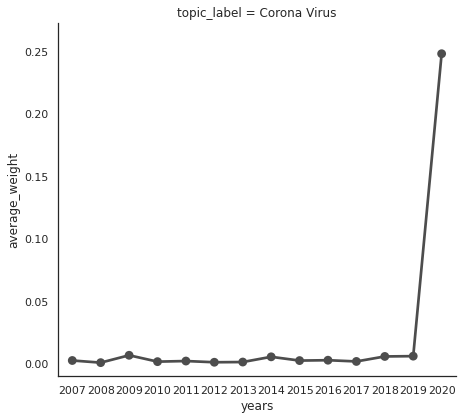

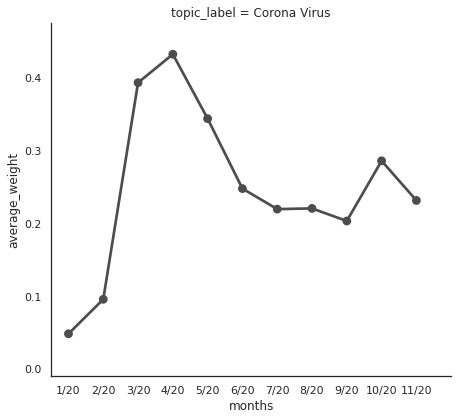

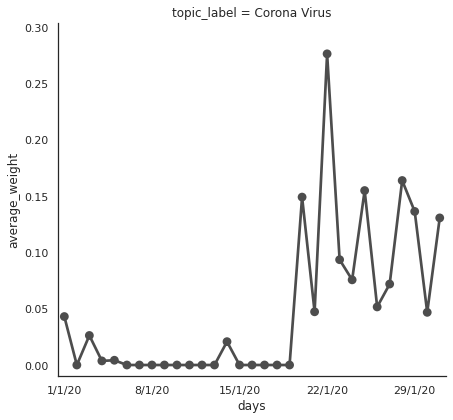

In [99]:
warnings.filterwarnings("ignore")

dfs = df12
# set range of all topics to plot all topics, here, just Corona-Virus is chosen
for i in range(12,13):
    sns.set(font_scale=1)
    sns.set_style("white")
    dfs = df12[(df12['topic'] == i)].reset_index()
    dfs.drop(columns=['Unnamed: 0'],inplace=True)
    # set year and month, which should be plotted
    dfs_days = dfs.loc[(dfs['year']==2020) & (dfs['month']==1)].reset_index().drop(columns='level_0')
    dfs_months = dfs.loc[(dfs['year']==2020)].reset_index().drop(columns='level_0')
    dfs_years = dfs
    
    #prepare plot
    topiic_labels = dfs['topic_label'].unique()
    dfs_years = dfs_years.rename(columns={"year":"years"})
    # use maximum average weights of the years
    years_max = dfs_years.groupby(['years'])['average_weight'].mean().max()
    
    g = sns.FacetGrid(dfs_years, col="topic_label", col_wrap=3, height=6, ylim=(-0.01, years_max*1.1))
    g.map(sns.pointplot, "years", 'average_weight', ci=None,color='.3')
    g.set(xticks=dfs_years["topic_label"].index[0:14])
    
    print("month to month:")
    # use maximum average weights of the month
    month_max = dfs_months.groupby(['months'])['average_weight'].mean().max()
    g = sns.FacetGrid(dfs_months, col="topic_label", col_wrap=3, height=6, ylim=(-0.01, month_max*1.1))
    g.map(sns.pointplot, "months", 'average_weight', ci=None,color='.3')
    g.set(xticks=dfs["topic_label"].index[:12])
    
    print("day to day:")
    # use maximum average weights of the days
    day_max = dfs_days.groupby(['days'])['average_weight'].mean().max()
    g = sns.FacetGrid(dfs_days, col="topic_label", col_wrap=3, height=6, ylim=(-0.01, day_max*1.1))
    g.map(sns.pointplot, "days", 'average_weight', ci=None,color='.3')
    g.set(xticks=dfs["topic_label"].index[::7][:5])